In [65]:
from regions.core import PixCoord
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.wcs import WCS, utils as wcsutils
from astropy.cosmology import Planck18
import scienceplots
import numpy as np
from photutils.aperture import CircularAperture

import astropy.visualization as vis
from astropy.io import ascii,fits
import matplotlib.pyplot as plt
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy import constants, units as u
from regions.shapes.circle import CircleSkyRegion,CirclePixelRegion
from regions.shapes import CircleAnnulusSkyRegion,CircleAnnulusPixelRegion,EllipseSkyRegion,EllipsePixelRegion
import importlib
import sys,os
from astropy.stats import sigma_clipped_stats
sys.path.append('/disk/bifrost/yuanze/software/KcwiKit/py')
sys.path.append('/disk/bifrost/yuanze/KBSS/CubEx_run/scripts')
import run_cubetools_v1 as ctools




root_directory="/disk/bifrost/yuanze/KBSS"
ascii_file_path = root_directory+'/KCWI/KBSS_faint_AGN.list'  # Path to the ASCII file
#ascii_file_path = root_directory+'/KCWI/qsos_bright_updated.list'  # Path to the ASCII file
save_to_path=root_directory+"/faint_qsos/result"  # Path to save the output files
source_table = ascii.read(ascii_file_path, format='ipac')

cdataroot="/disk/bifrost/yuanze/my_work/xray/chandra/KBSS"
catroot="/disk/bifrost/yuanze/KBSS"
prop_all={"Q1700":["8032","8033","9756","9757","9758", "9759","9760","9767"],\
          "LyC22":["8034","8035","8036","9717","1694"],
         "GWS":["5849","5850","6218","6219","9458","9459","9460","9461","9734","9735",\
                "9736","9737","9738","9739","9740","10769","3305","4357","4365","16027","17487"],
         "Q1549":["27226","27227","27228","27229","27230","27231","27691","27692","29202","29203","29430"],
         "Q0207":["17078","6820"]}
erange=["broad","0.5-2.0","hard"]
dtype="KBSS"
field="Q1549"
name="Lab5"
filters = [f"table['Name']=='{name}'",f"table['Field']=='{field}'"]#,"table['Name'] != 'FSzP1170'","table['Name'] != 'Lab5'"]
try:
    all_directories,qsotab,data_dir = ctools.find_directories_from_ascii(source_table, root_directory,filters=filters,KBSS=(dtype=="KBSS"))
    redshift=qsotab["zlya"][0]
    RA=qsotab["RA"][0]
    Dec=qsotab["Decl"][0]
except:
    # Map the sentinel strings/numbers in your file to NaN.
    fill = [
        ('n/a', np.nan),
        ('---', np.nan),
     #   ('-1.0000', np.nan),   # e.g. z unknown
      #  ('-2.0000', np.nan),   # e.g. not observed / not applicable
    ]

    t = ascii.read(
        catroot+f"/cats/z.{field.lower()}_kbss.cat",
        format="basic",        # whitespace-delimited
        quotechar='"',         # keep entire comments field intact
        fill_values=fill
      #  fast_reader=True,      # speed
     #   guess=False
    )
    df=t.to_pandas()
    qsotab=df[(df["FIELD"] == field) & (df["NAME"] == name)]
    redshift=qsotab["zlya"].iloc[0]
    RA=qsotab["RA"].iloc[0]
    Dec=qsotab["DEC"].iloc[0]
#RA="15:52:03.3489"
#Dec="+19:12:51.688"
sc = SkyCoord(ra=RA, dec=Dec, unit='deg',frame='icrs', equinox='J2000')
#sc = SkyCoord(ra=RA, dec=Dec, unit=(u.hourangle,u.degree),frame='icrs', equinox='J2000')

ldist=Planck18.luminosity_distance(redshift).to(u.cm).value
print("Source position at",sc.to_string("hmsdms"))

Source position at 15h52m03.6s +19d12m52.272s


In [70]:
Dec

19.21452

In [45]:
SkyCoord(ra="15:52:41.4", dec="19:15:10.0",unit=(u.hourangle,u.degree))

<SkyCoord (ICRS): (ra, dec) in deg
    (238.1725, 19.25277778)>

Set MJD-END to 60555.119838 from DATE-END'. [astropy.wcs.wcs]


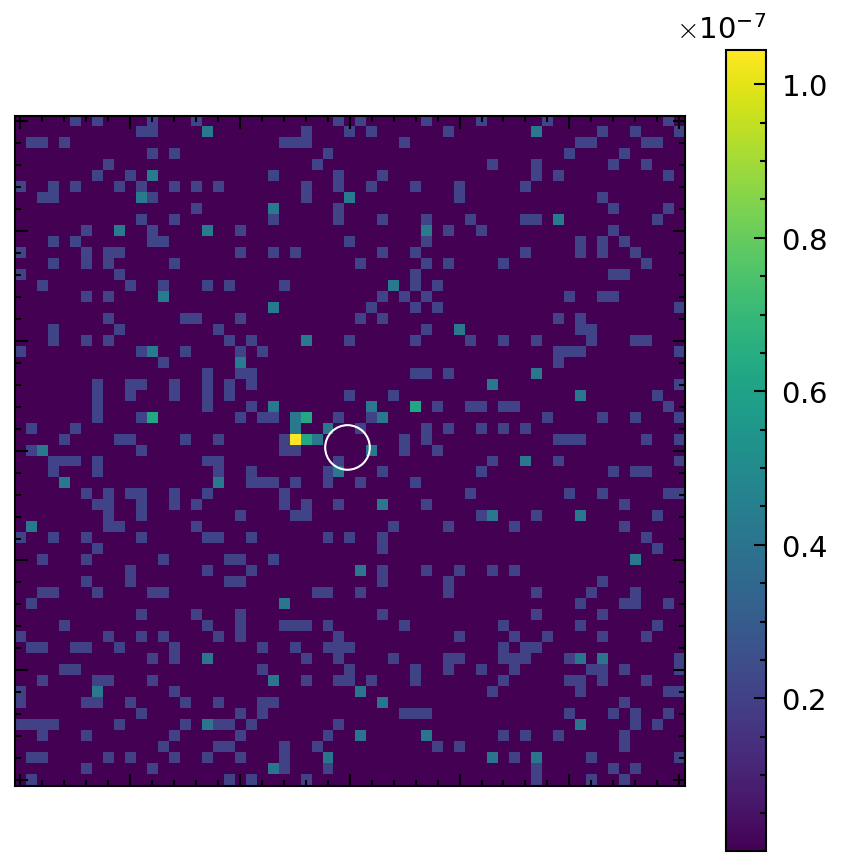

In [64]:


from matplotlib import cm, ticker

stacked=True
if stacked:
    prop=[field]
else:
    prop=prop_all[field]


for i in prop:
    cdata=os.path.join(cdataroot,i)
    
    for ne in [0]:
        # ne:energy range, 0:0.5-7, broadband;  1:0.5-2.0 keV; 2: 2.-7. keV
        if stacked:
            chdu=fits.open(cdata+f"/{erange[ne]}_flux.img")
        else:
            chdu=fits.open(cdata+f"/fluxed/{erange[ne]}_flux.img")

        imagecut=True

        #43.507395, 14.976920

        plt.style.use(["science",'no-latex'])
        plt.rcParams.update({
            "font.family": "dejavu sans",   # specify font family here
            "font.serif": ["Times"],  # specify font here
            "font.size":7,
        "legend.fancybox":True})

        cutsize_arcsec=60 #arcsec
        wcsall=WCS(chdu[0].header)
        # Calculate the size of the cutout in pixels
        pix_scale = wcsall.pixel_scale_matrix[1, 1] * 3600  # scale in arcsec/pixel
        cutsize_pixels = cutsize_arcsec / pix_scale

        # Create a cutout around the target coordinates
        if imagecut:
            try:
                image = Cutout2D(chdu[0].data, sc, size=cutsize_pixels, wcs=wcsall)
                wcs=image.wcs
            except:
                print("source(s) not found")
        else:
            image=chdu[0]
            wcs=wcsall
        wcsinfo=wcs


        ##=======================PSF fitting setup=================#
        imdata=image.data
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3),dpi=300)
        #norm = vis.simple_norm(imdata, 'linear', percent=99)
        _, med, std = sigma_clipped_stats(imdata)
        norm = vis.ImageNormalize(vmin = 1e-3*np.max(imdata), vmax = 1*np.max(imdata),stretch = vis.LinearStretch())

        im=ax.imshow(imdata, origin='lower', norm=norm)
        plt.colorbar(mappable=im)
        #ax[1].imshow(imdata - resid, origin='lower', norm=norm)
        #im = ax[2].imshow(resid, origin='lower',norm=norm)
        #ax[0].set_title('Data')
        #ax[1].set_title('Model')
        #ax[2].set_title('Residual Image')


        #for axx in ax:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        #fig.savefig(multiAGNpath+"/"+field+"/fig/{}_{}_{}.pdf".format(datatype,inst.split("/")[0],inst.split("/")[1]))
        plt.tight_layout()
        
        if stacked:
            aper = CircleSkyRegion(sc, 2*u.arcsec)
            aper.to_pixel(wcsinfo).plot(color="white",ax=ax,lw=0.5)
        else:
            aper = CircleSkyRegion(sc, 1*u.arcsec)
            aper.to_pixel(wcsinfo).plot(color="white",ax=ax)
            #aper = CircleSkyRegion(sc, 25*u.arcsec)
            #aper.to_pixel(wcsinfo).plot(color="white",ax=ax)
            #aper = CircleSkyRegion(sc, 45*u.arcsec)
            #aper.to_pixel(wcsinfo).plot(color="white",ax=ax)
        #phot.sort("y_init")
        # 3 objects, write Lx
        #fac=1/p2e[ne][0]*p2e[ne][1]*4*np.pi*Planck18.luminosity_distance(0.03145).to(u.cm).value**2
        #Lxerr[erange[ne]]=np.array([std_devs[0]]+[std_devs[i] for i in range(3,5)])*fac
        #Lx[erange[ne]]=[fit_model[i].flux*fac for i in range(3)]
        fig.savefig(save_to_path+"/{}-{}_{}_{}_fitted.pdf".format(field,name,erange[ne],i))


In [11]:
import xspec
#xspec.plt.clf()

lw = 2   # Line widths throughout the plot
fsz = 16 # Font size throughout the plot

specpath=cdataroot+f"/{field}-{name}"

#xspec.plt.rc('axes', labelsize=14)  # fontsize of the x any y labels

# Load local models
#AllModels.lmod("relxill")

# Energies
#AllModels.setEnergies("/disk/bifrost/yuanze/my_work/pub3/specE_n{}_logxi_{}.txt".format(density,logxi))
# Define the Model
#m1 = Model("atable{/disk/bifrost/yuanze/reflionx/reflionx_HD_nthcomp_v2.fits}")
os.chdir(specpath)
xspec.Xset.restore("test2.xcm")
#xspec.AllModels.setEnergies("0.2 10. 980 linear")
xspec.Plot.setRebin(minSig=1,maxBins=1000,groupNum=-1,errType="quad")
xspec.Plot.redshift=0
xspec.Plot("euf ra emo ld back")
xda = np.array(xspec.Plot.x())
xdaerr = np.array(xspec.Plot.xErr())
xmo = np.array(xspec.Plot.x(plotWindow=3))
mo = np.array(xspec.Plot.model(plotWindow=3))

#addcomp1=np.array(xspec.Plot.addComp(addCompNum=1, plotGroup=1, plotWindow=3))
#addcomp2=np.array(xspec.Plot.addComp(addCompNum=2, plotGroup=1, plotWindow=3))


yda = np.array(xspec.Plot.y())
ydaerr = np.array(xspec.Plot.yErr())
yra  = np.array(xspec.Plot.y(plotWindow=2))
yraerr  = np.array(xspec.Plot.yErr(plotWindow=2))

xback = np.array(xspec.Plot.x(plotWindow=5))
xbackerr = np.array(xspec.Plot.xErr(plotWindow=5))

yback = np.array(xspec.Plot.y(plotWindow=5))
ybackerr = np.array(xspec.Plot.yErr(plotWindow=5))

xld = np.array(xspec.Plot.x(plotWindow=4))
yld = np.array(xspec.Plot.y(plotWindow=4))
ylderr = np.array(xspec.Plot.yErr(plotWindow=4))

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic  : C-Statistic                  273.37     using 420 bins.

Test statistic : Chi-Squared              1.901136e+06     using 420 bins.
 Null hypothesis probability of 0.000000e+00 with 417 degrees of freedom
 Current data and model not fit yet.

Spectrum #: 1 replaced 

1 spectrum  in use
 
Spectral Data File: combined_src_bin.pi  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.141e-03 +/- 7.788e-05 (96.8 % total)
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-763
  Telescope: CHANDRA Instrument: ACIS  Channel Type: PI
  Exposure Time: 1.943e+05 sec
 Using fit statistic: cstat
 Using Background File                combined_bkg.pi
  Background Exposure Time: 1.943e+05 sec
 Using Response (RMF) File            combined_src.rmf for Source 1
 Using Auxiliary Response (ARF) F
***Warning: The file sent to Xset.restore(): test2.xcm
    is not detected 

(0.1, 6.0)

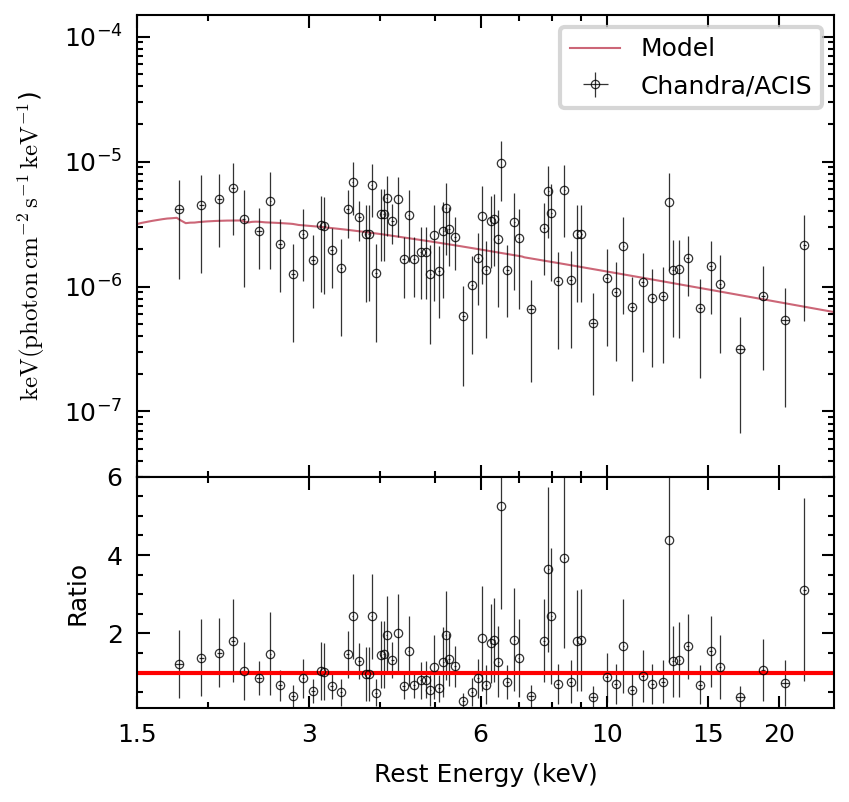

In [17]:
#Ploting spectra for publication
import scienceplots
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":6,
"legend.fancybox":True})
#z=
lw=0.5
numrow=2
numcol=1
colorlst=["#CC6677","#88CCEE","#6699CC"]
fig=plt.figure(figsize=(3,3),dpi=300)
gs = fig.add_gridspec(numrow, numcol,height_ratios=[2,1],hspace=0.0)
axs=gs.subplots(sharex=True)

axs[0].plot(xmo*(1+redshift),mo,color=colorlst[0],ms=0.5,label="Model",lw=lw)
#axs[0].plot(xmo,addcomp1,color=colorlst[2],ms=0.5,ls="--",lw=lw)
#axs[0].plot(xmo,addcomp2,color=colorlst[2],ms=0.5,ls="--",lw=lw)

axs[0].errorbar(xda*(1+redshift),yda,xerr=xdaerr,yerr=ydaerr,fmt="ko",mfc="none",mew=0.3,ms=2,lw=0.3,alpha=0.8,label="Chandra/ACIS")

axs[1].errorbar(xda*(1+redshift),yra,xerr=xdaerr,yerr=yraerr,fmt="ko",mfc="none",mew=0.3,ms=2,lw=0.3,alpha=0.8)

#axs.set_xscale("log")
axs[0].legend(frameon=True)
axs[1].set_ylabel("Ratio")

#axs[1].text(0.02,0.85,r"C-stat/DOF=121.28/194",transform=axs[1].transAxes)
#axs[1].set_ylim([0,7.5])
axs[1].axhline(1,color="r")
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[1].set_xlabel("Rest Energy (keV)")
axs[0].set_ylabel(r"$\rm keV(photon\,cm^{-2}\,s^{-1}\,keV^{-1}$)")
axs[0].set_xlim([1.5,25])
axs[0].set_ylim([3e-8,1.5e-4])
xarray=[1.5,3,6,10,15,20]
axs[1].set_xticks(xarray)
axs[1].set_xticklabels(xarray)
axs[1].set_ylim(0.1,6.0)
#plt.axvline(x=)
#axs=plt.gca()
#axs[0].text(0.05,0.92,r"$n=10^{%s}\,$cm$^{-3}$"%density,transform=axs[0].transAxes)
#axs[0].text(0.05,0.87,r"Log$[\,\xi/$erg$\,$cm$\,$s$^{-1}]=%s $"%logxi,transform=axs[0].transAxes)


#fig.savefig("/disk/bifrost/yuanze/multiAGN/UGC2369/fig/chandra_spec.pdf")

In [2]:
ld=Planck18.luminosity_distance(2.84)

In [4]:
1e-16*u.erg*u.cm**(-2)/u.s*4*np.pi*ld.to(u.cm)**2

<Quantity 7.09888307e+42 erg / s>

In [47]:
5*u.keV.to(u.erg)*2e-8

1.602176634e-16